<a href="https://colab.research.google.com/github/ManikantaPinabakala/slashMarkProject3/blob/main/SlashMark_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import cv2 as cv
import matplotlib.pyplot as plt

In [10]:
def getFaceBox(net, frame, conf_threshold=0.7):
  frameOpenCVDNN = frame.copy()
  frameHeight = frameOpenCVDNN.shape[0]
  frameWidth = frameOpenCVDNN.shape[1]
  blob = cv.dnn.blobFromImage(
    frameOpenCVDNN, 1.0, (300, 300), [104, 117, 123], True, False
  )

  net.setInput(blob)
  detections = net.forward()
  faces = []

  for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > conf_threshold:
      x1 = int(detections[0, 0, i, 3] * frameWidth)
      y1 = int(detections[0, 0, i, 4] * frameHeight)
      x2 = int(detections[0, 0, i, 5] * frameWidth)
      y2 = int(detections[0, 0, i, 6] * frameHeight)

      faces.append([x1, y1, x2, y2])

      cv.rectangle(
        frameOpenCVDNN,
        (x1, y1),
        (x2, y2),
        (0, 255, 0),
        int(round(frameHeight / 150)),
        8,
      )
  return frameOpenCVDNN, faces

In [11]:
faceProto = "pretrained_models/opencv_face_detector.pbtxt"
faceModel = "pretrained_models/opencv_face_detector_uint8.pb"
ageProto = "pretrained_models/age_deploy.prototxt"
ageModel = "pretrained_models/age_net.caffemodel"
genderProto = "pretrained_models/gender_deploy.prototxt"
genderModel = "pretrained_models/gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)

ageList = [
  "(0-2)",
  "(4-6)",
  "(8-12)",
  "(15-20)",
  "(25-32)",
  "(38-43)",
  "(48-53)",
  "(60-100)",
]

genderList = ["Male", "Female"]

In [12]:
# Load network
ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)
padding = 20

def age_gender_detector(frame):
  frameFace, faces = getFaceBox(faceNet, frame)
  for bbox in faces:
    face = frame[
      max(0, bbox[1] - padding) : min(bbox[3] + padding, frame.shape[0] - 1),
      max(0, bbox[0] - padding) : min(bbox[2] + padding, frame.shape[1] - 1),
    ]

    blob = cv.dnn.blobFromImage(
      face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False
    )

    genderNet.setInput(blob)
    genderPreds = genderNet.forward()
    gender = genderList[genderPreds[0].argmax()]

    print("Gender: {}, conf = {:.3f}".format(gender, genderPreds[0].max()))

    ageNet.setInput(blob)
    agePreds = ageNet.forward()
    age = ageList[agePreds[0].argmax()]

    print("Age: {}, conf = {:.3f}\n".format(age, agePreds[0].max()))

    label = f"{gender}, {age}"
    cv.putText(
      frameFace,
      label,
      (bbox[0], bbox[1] - 10),
      cv.FONT_HERSHEY_DUPLEX,
      0.5,
      (0, 255, 255),
      2,
      cv.LINE_AA,
    )
  return frameFace

Gender: Male, conf = 1.000
Age: (25-32), conf = 0.840



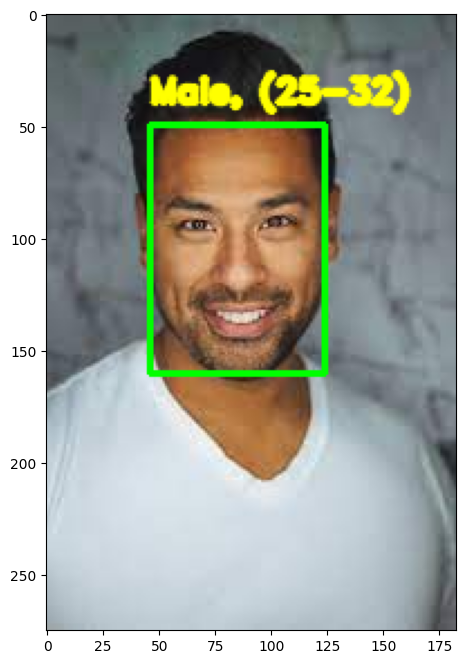

In [13]:
# A function to make predictions on a particular image
def show_results(img_path):
  img = cv.imread(img_path)
  output = age_gender_detector(img)
  rgb_output = cv.cvtColor(output, cv.COLOR_BGR2RGB)
  plt.figure(figsize=(8, 8))
  plt.imshow(rgb_output)
  plt.show()

# Here, you can add images into your directory and give its path inside the function
# to get predictions on the image.
# Remember, the Gender and Age prediction values are displayed both on the image
# and in the terminal as well.
# But the confidence values of the predictions are only displayed in the terminal
show_results("sample_images/sample_image_male_1.jpeg")